# Resnet Transfer Learning and FineTuning
> https://wiserloner.tistory.com/1244

## 0. 라이브러리

In [25]:
!pip install -q -U tf-hub-nightly

## 설치 및 임포트

In [26]:
import matplotlib.pylab as plt
import tensorflow as tf
import os
import numpy as np
import PIL.Image as Image
import tensorflow_hub as hub
import pathlib

from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

## 데이터 준비

In [27]:
# 꽃 이미지 다운로드

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [28]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [29]:
# 클래스 이름을 가져오기

class_names = train_dataset.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [30]:
# 이미지의 shape를 알아보기

for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [31]:
# 데이터셋 shuffle, prefetch

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

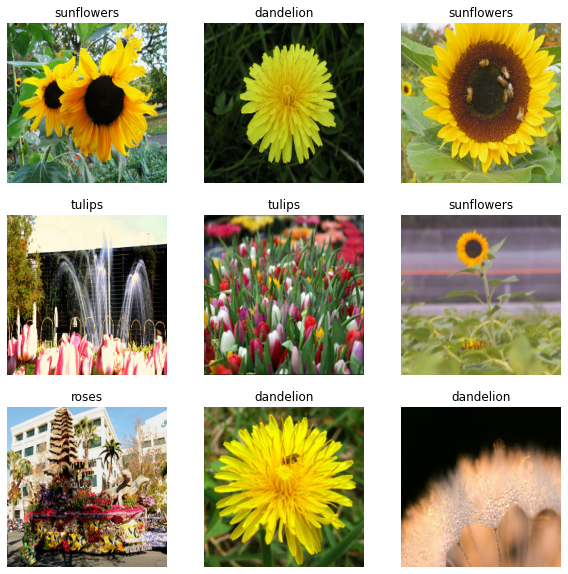

In [32]:
# 이미지 샘플 9개를 확인

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 데이터 전처리

In [33]:
# 이미지 분석에 있어서 없어선 안될 데이터 증강을 레이어로 만들어서 추후 모델에 포함시킬것임.
# 각 순전파마다 자동으로 데이터 증강이 되며, 매 학습마다 다른 이미지로 학습하는 결과를 만들어줌.
# (실전에서는 모델에 포함시키는게 아니라 학습 프로세스를 변경하여 학습시에만 이를 순전파시켜 이미지를 증강시킬것임.)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

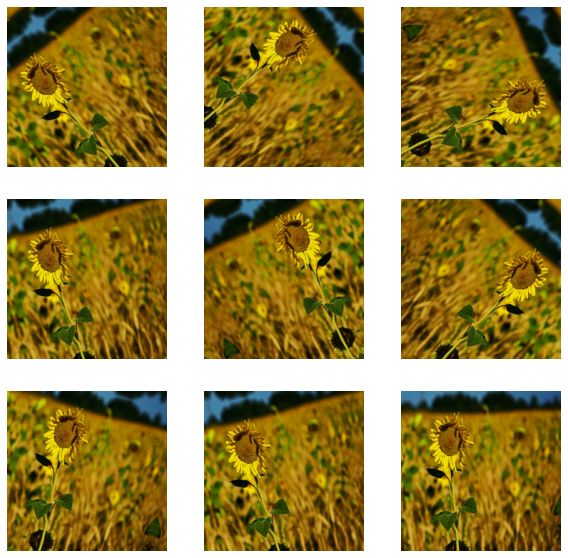

In [34]:
# 데이터 증강 효과를 확인하려면 위와 같이 시각화.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [41]:
# 데이터 스케일링 레이어
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255)

## 특징 추출 모델 가져오기

In [42]:
# Create the base model from the pre-trained model Resnet v2 50
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

IMG_SHAPE = IMG_SIZE + (3,)
base_model = hub.KerasLayer(feature_extractor_url, input_shape=IMG_SHAPE)

In [43]:
IMG_SHAPE

(224, 224, 3)

In [44]:
# 모델 고정
base_model.trainable = False

## 모델 만들기

In [45]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(inputs, outputs)

In [46]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_2 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 23,575,045
Trainable params: 10,245
Non-trainable params: 23,564,800
__________________________________________

## 학습

In [47]:
# 컴파일 후 학습

initial_epochs = 10

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=initial_epochs
)

Epoch 1/10
92/92 [==============================] - 14s 125ms/step - loss: 0.7815 - accuracy: 0.7101 - val_loss: 0.4630 - val_accuracy: 0.8351
Epoch 2/10
92/92 [==============================] - 10s 112ms/step - loss: 0.4613 - accuracy: 0.8372 - val_loss: 0.4073 - val_accuracy: 0.8515
Epoch 3/10
92/92 [==============================] - 10s 111ms/step - loss: 0.3877 - accuracy: 0.8661 - val_loss: 0.3700 - val_accuracy: 0.8597
Epoch 4/10
92/92 [==============================] - 10s 110ms/step - loss: 0.3494 - accuracy: 0.8791 - val_loss: 0.3409 - val_accuracy: 0.8733
Epoch 5/10
92/92 [==============================] - 10s 110ms/step - loss: 0.3185 - accuracy: 0.8900 - val_loss: 0.3294 - val_accuracy: 0.8733
Epoch 6/10
92/92 [==============================] - 10s 109ms/step - loss: 0.3041 - accuracy: 0.8958 - val_loss: 0.3277 - val_accuracy: 0.8692
Epoch 7/10
92/92 [==============================] - 10s 109ms/step - loss: 0.2852 - accuracy: 0.8988 - val_loss: 0.3131 - val_accuracy: 0.8787

## 시각화

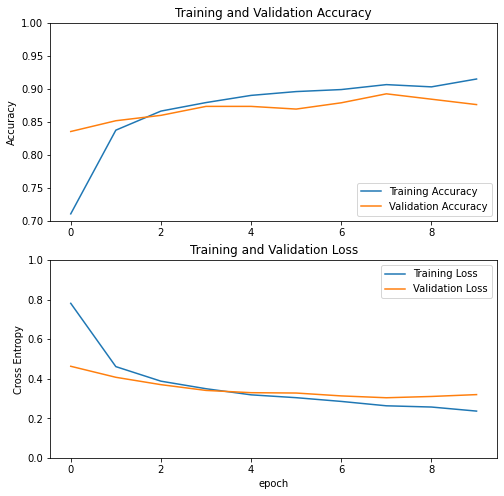

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 파인튜닝

In [49]:
# 앞쪽에서 모델 학습시 10번 epoch을 했는데, 그뒤를 이어서 11번 epoch부터 학습진행
# 11번부터 학습시 base_model.trainable = True 주어 base_model도 학습되도록 함.

base_model.trainable = True
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
92/92 [==============================] - 10s 110ms/step - loss: 0.2337 - accuracy: 0.9196 - val_loss: 0.3323 - val_accuracy: 0.8787
Epoch 11/20
92/92 [==============================] - 10s 110ms/step - loss: 0.2376 - accuracy: 0.9111 - val_loss: 0.3239 - val_accuracy: 0.8842
Epoch 12/20
92/92 [==============================] - 10s 110ms/step - loss: 0.2195 - accuracy: 0.9223 - val_loss: 0.3172 - val_accuracy: 0.8883
Epoch 13/20
92/92 [==============================] - 10s 110ms/step - loss: 0.2268 - accuracy: 0.9189 - val_loss: 0.3035 - val_accuracy: 0.8951
Epoch 14/20
92/92 [==============================] - 10s 110ms/step - loss: 0.2242 - accuracy: 0.9206 - val_loss: 0.3030 - val_accuracy: 0.8951
Epoch 15/20
92/92 [==============================] - 10s 110ms/step - loss: 0.2072 - accuracy: 0.9240 - val_loss: 0.3012 - val_accuracy: 0.8828
Epoch 16/20
92/92 [==============================] - 10s 110ms/step - loss: 0.2088 - accuracy: 0.9244 - val_loss: 0.3104 - val_accuracy:

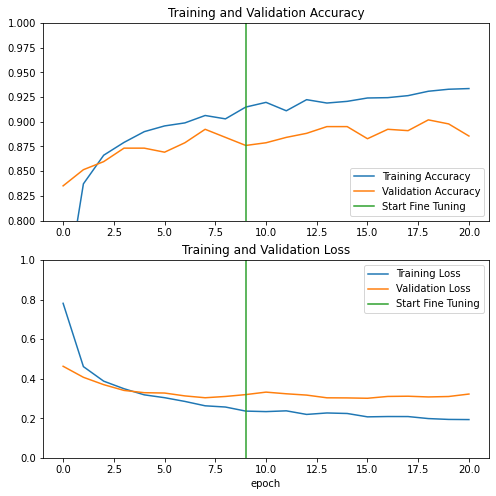

In [50]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()